In [1]:
import simsz.make_dm_halo as make_dm_halo
import simsz.utils as utils
from simsz import simtools, noise, filters
import make_sz_cluster
import simsz.load_vars as load_vars
from colossus.halo import mass_adv

import time
from datetime import datetime as dt
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import h5py
from pixell import enmap, powspec, enplot
import camb
#import healpy
import scipy

from astropy.constants import M_sun
from astropy.constants import G, sigma_T, m_e, c, h, k_B
from astropy import units as u

In [2]:
# # Set the size of the box in degrees and convert to radians to load in only part of these maps
dec_from, dec_to = np.deg2rad([-5,5])
ra_from, ra_to = np.deg2rad([-10, 20])

# # Create the box
box = [[dec_from,ra_from],[dec_to,ra_to]]

# # read in the map
# imap = enmap.read_map(path + "act_planck_dr5.01_s08s18_AA_f150_night_map.fits", box = box)[0]

img=enmap.read_map("act_dr5.01_s08s18_AA_f150_daynight_map.fits",box=box)[0]
ivar=enmap.read_map("act_dr5.01_s08s18_AA_f150_daynight_ivar.fits",box=box)[0]

In [10]:
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

In [ ]:
keys = {"downgrade": 8, "ticks": 10, "colorbar": True} 
eshow(img, **keys)

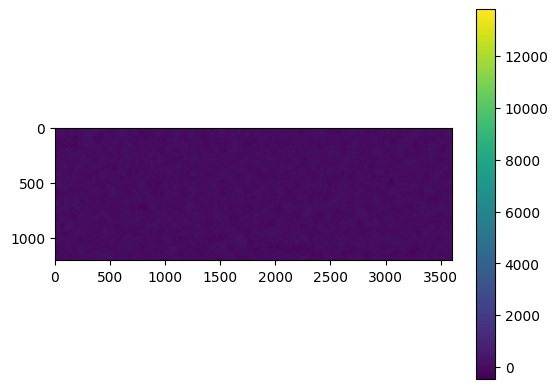

In [4]:
#This is the map
im=plt.imshow(img)
cbar = plt.colorbar(im)

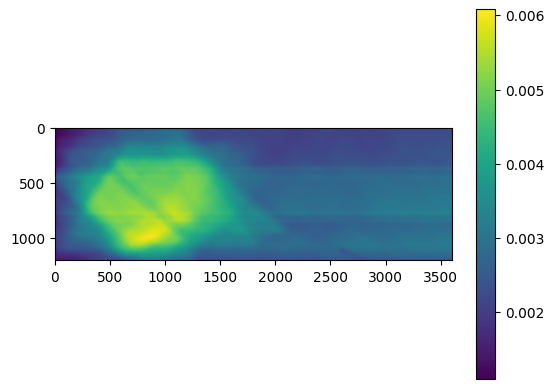

In [5]:
#This is the noise map
im2=plt.imshow(ivar)
cbar = plt.colorbar(im2)

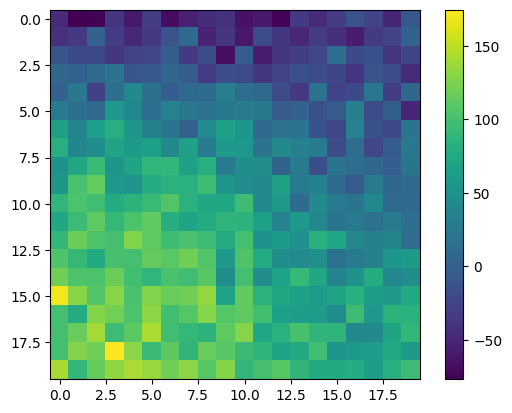

In [9]:
#Plotting individual submaps centered on confirmed clusters, arXiv:1301.0816
#ACT-CL J0008.1+0201
#Set up a box around dec = -2.0204 and ra = 2.0418
#dec,ra = np.deg2rad([-2.0204,2.0418]) 
dec,ra = np.deg2rad([-3.0152,-0.7693]) 

# Give the box a width of 10 arcmin
W = 0.166667
width = np.deg2rad(0.166667)

# Create the box and use it to select a submap
box = [[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]]

# Because the original cutout of the full map that we read in doesn't include this particular box you can read it in again at this location
# or use the downgraded

submap=img.submap(box)

im3=plt.imshow(submap)
cbar = plt.colorbar(im3)
